# i. Perkenalan

Nama    : Ibrahim Hasan

Batch   : FTDS009

Dataset yang digunakan adalah data yang berisi direct marketing campaign melalui telepon pada suatu Bank di Negara Portugal.

Objektif yang ingin dicapai adalah membuat beberapa machine learning model klasifikasi yang dapat memprediksi apakah seorang nasabah bersedia menaruh uangnya pada produk deposito pada Bank tersebut.

Selanjutnya dari hasil penghitungan cross validation masing-masing model, ditentukan model terbaik yang akan dioptimalkan dengan metode GridSearchCV dan model tersebut selanjutnya akan diimplementasikan pada inference set.

# ii. Import Libraries

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from feature_engine.outliers import Winsorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# iii. Data Loading

In [275]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Observasi nilai missing value pada dataset, sekilas terlihat tidak ada missing value bernilai Nan.

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# iv. Exploratory Data Analysis

Observasi `label` dari dataset yang digunakan dan terdapat imbalance data. Oleh karena itu pada preprocessing akan dilakukan upsampling agar data menjadi balanced.

In [277]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Observasi data dengan describe(), sekilas terlihat pada feature `age` terdapat nasabah dengan umur 98 tahun. Selanjutnya akan dilakukan observasi lebih lanjut apakah datapoint tersebut merupakan outlier atau bukan.

In [278]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


Setelah dilakukan observasi lebih lanjut, ternyata data point tersebut bukan outlier dan terdapat beberapa data point yang memiliki umur diatas 90 tahun juga.

In [279]:
df.loc[df['age']>0, ['age', 'y']].sort_values(by= 'age', ascending=False).head(10)

,age,y
38452,98,yes
38455,98,yes
27826,95,no
38921,94,no
39655,92,no
40450,92,yes
39734,92,yes
40469,92,yes
38032,91,no
38022,91,no


Mengganti nilai pada `label` dari object menjadi integer agar dapat melihat korelasi dengan feature lainnya pada heatmap.

In [280]:
df.y = df.y.replace({'no': 0, 'yes': 1})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


Observasi korelasi antara feature dengan heatmap. Untuk feature yang dianggap memiliki korelasi dengan `label`, selanjutnya akan dilakukan observasi lebih lanjut tentang mendeteksi outlier dan missing value.

<AxesSubplot:>

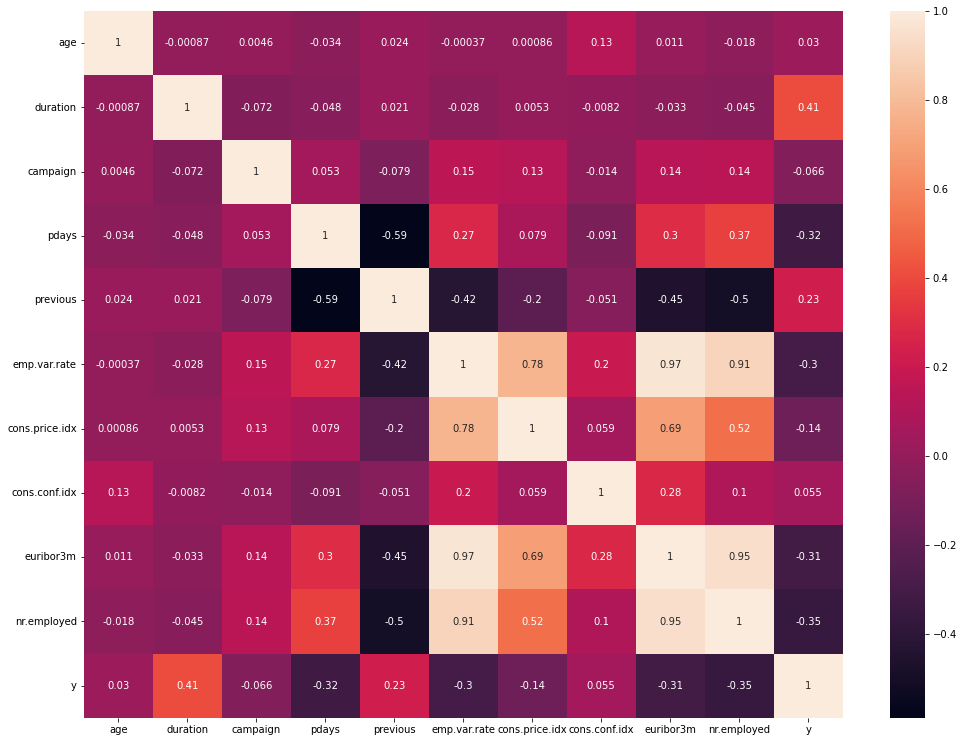

In [281]:
plt.figure(figsize=(17,13))
sns.heatmap(df.corr(),annot=True)

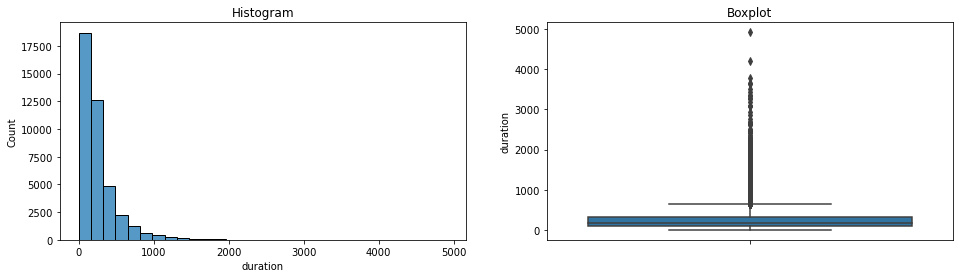


Skewness Value :  3.263141255262832


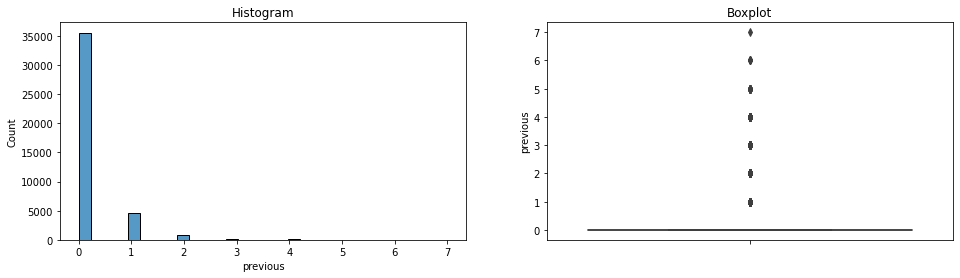


Skewness Value :  3.8320422428611836


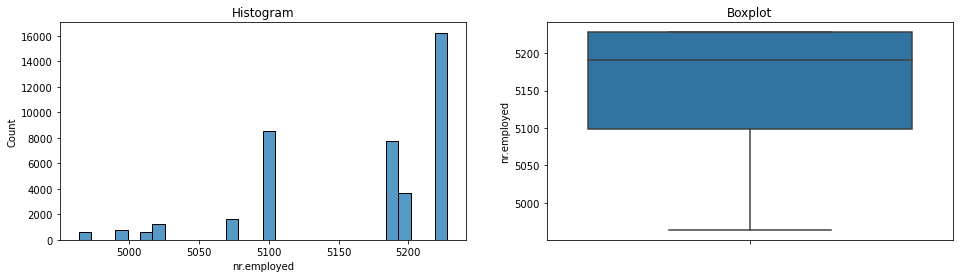


Skewness Value :  -1.044262407089151


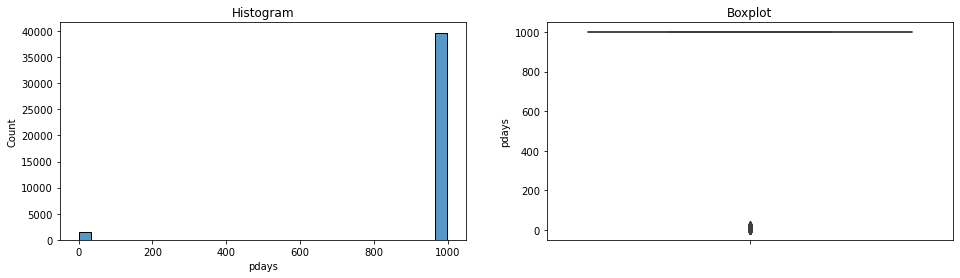


Skewness Value :  -4.922189916418162


In [341]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

diagnostic_plots(df, 'duration')
print('\nSkewness Value : ',df['duration'].skew())

diagnostic_plots(df, 'previous')
print('\nSkewness Value : ', df['previous'].skew())

diagnostic_plots(df, 'nr.employed')
print('\nSkewness Value : ', df['nr.employed'].skew())

diagnostic_plots(df, 'pdays')
print('\nSkewness Value : ', df['pdays'].skew())

Observasi missing value pada feature `job`. Terdapat nilai `unknown` pada feature tersebut.

In [283]:
df.job.value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

Begitu juga dengan feature `education`, `default`, dan `loan` yang memiliki nilai unknown.

In [284]:
df.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [285]:
df.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [286]:
df.loan.value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

Observasi missing value pada feature `pdays` dimana nilai 999 merupakan missing value.

In [287]:
df.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

# v. Data Preprocessing

Sebagaimana hasil observasi EDA yang menemukan data imbalance, langkah pertama yang dilakukan pada preprocessing adalah melakukan upsampling agar data menjadi balanced.

In [288]:
y_majority = df[df.y == 0]
y_minority = df[df.y == 1]

y_minority_upsampled = resample(y_minority, replace=True, n_samples=y_majority.shape[0], random_state=123)

y_upsampled = pd.concat([y_majority, y_minority_upsampled])

print(y_upsampled.y.value_counts())
print(y_upsampled.shape)

0    36548
1    36548
Name: y, dtype: int64
(73096, 21)


Untuk mengurangi nilai unknown pada data dengan kategori MNAR, dilakukan pengisian dengan mempertimbangkan nilai dari `feature` lainnya. Sedangkan untuk missing value pada feature `pdays` yang merupakan kategori MCAR, penulis akan membiarkan nilai tersebut karena tidak menemukan pola dan justifikasi terbaik untuk mengisi nilai tersebut.

In [289]:
y_upsampled.loc[(y_upsampled['age']>60) & (y_upsampled['job']=='unknown'), 'job'] = 'retired'
y_upsampled.loc[(y_upsampled['education']=='unknown') & (y_upsampled['job']=='management'), 'education'] = 'university.degree'
y_upsampled.loc[(y_upsampled['education']=='unknown') & (y_upsampled['job']=='services'), 'education'] = 'high.school'
y_upsampled.loc[(y_upsampled['education']=='unknown') & (y_upsampled['job']=='housemaid'), 'education'] = 'basic.4y'
y_upsampled.loc[(y_upsampled['job'] == 'unknown') & (y_upsampled['education']=='basic.4y'), 'job'] = 'blue-collar'
y_upsampled.loc[(y_upsampled['job'] == 'unknown') & (y_upsampled['education']=='basic.6y'), 'job'] = 'blue-collar'
y_upsampled.loc[(y_upsampled['job'] == 'unknown') & (y_upsampled['education']=='basic.9y'), 'job'] = 'blue-collar'
y_upsampled.loc[(y_upsampled['job']=='unknown') & (y_upsampled['education']=='professional.course'), 'job'] = 'technician'

Preview dari feature `job` dan `education` setelah upsampling dan mengurangi nilai unknown.

In [290]:
y_upsampled.job.value_counts()

admin.           19797
blue-collar      13788
technician       11764
services          6258
management        5140
retired           4681
student           2768
self-employed     2449
entrepreneur      2342
unemployed        1982
housemaid         1779
unknown            348
Name: job, dtype: int64

In [291]:
y_upsampled.education.value_counts()

university.degree      23832
high.school            17030
professional.course     9331
basic.9y                9323
basic.4y                7122
basic.6y                3583
unknown                 2825
illiterate                50
Name: education, dtype: int64

Langkah selanjutnya adalah mulai untuk splitting dataset, yang pertama adalah menunjuk model inference

In [292]:
d_inf = y_upsampled.sample(10, random_state=39)

Drop inference set untuk mendapatkan dataset training dan testing.

In [293]:
# remove inference & reset index

data_train_test = y_upsampled.drop(d_inf.index)
data_train_test

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36577,33,management,divorced,university.degree,no,yes,no,cellular,jun,wed,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,1
37277,38,admin.,single,high.school,no,yes,yes,cellular,aug,mon,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,1
9157,52,self-employed,married,basic.4y,unknown,no,yes,telephone,jun,fri,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,1
36369,25,admin.,single,university.degree,no,no,no,cellular,jun,tue,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,1


Reset index pada inference set, dataset training dan testing.

In [294]:
data_train_test.reset_index(drop=True, inplace=True)
d_inf_ind = d_inf.reset_index(drop=True)

Split feature dan label lalu menunjuk `y` sebagai label.

In [295]:
X = data_train_test.drop(['y'], axis=1)
y = data_train_test['y']
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73051,33,management,divorced,university.degree,no,yes,no,cellular,jun,wed,187,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2
73052,38,admin.,single,high.school,no,yes,yes,cellular,aug,mon,167,1,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2
73053,52,self-employed,married,basic.4y,unknown,no,yes,telephone,jun,fri,381,2,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
73054,25,admin.,single,university.degree,no,no,no,cellular,jun,tue,417,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2


Split dataset training dan testing dengan proporsi 80% training dan 20% testing.

In [296]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

print(X_train.shape)
print(X_test.shape)

(58444, 20)
(14612, 20)


Atas Observasi outlier pada EDA, dilakukan winsorizing pada feature yang dianggap memiliki korelasi dengan `label` yaitu feature `duration`. Setelah handling outlier, nilai skewness tercatat lebih baik dibandingkan sebelumnya.

In [297]:
windsoriser = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['duration'])

windsoriser.fit(X_train)

X_train_w = windsoriser.transform(X_train)

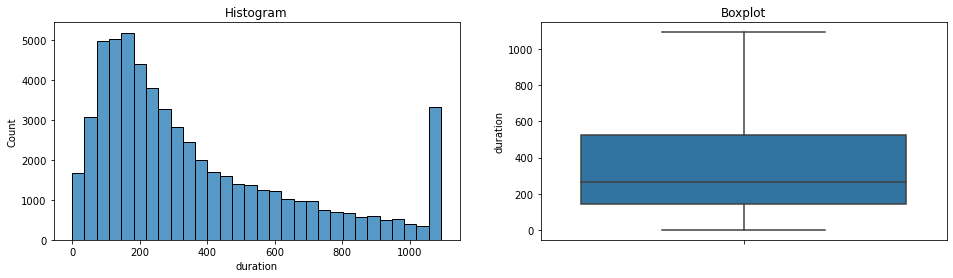


Skewness Value :  1.083908732988885


In [298]:
diagnostic_plots(X_train_w, 'duration')
print('\nSkewness Value : ', X_train_w['duration'].skew())

Feature Selection

mengeliminasi feature-feature yang tidak memiliki nilai korelasi signifikan terhadap label berdasarkan heatmap.

In [299]:
X_train_fs = X_train_w.drop(['marital', 'contact', 'month', 'day_of_week', 'campaign', 'cons.price.idx', 'cons.conf.idx'], axis=1)
X_test_fs = X_test.drop(['marital', 'contact', 'month', 'day_of_week', 'campaign', 'cons.price.idx', 'cons.conf.idx'], axis=1)

X_train_fs

,age,job,education,default,housing,loan,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed
68797,61,admin.,university.degree,no,yes,yes,261.0,999,0,nonexistent,-2.9,1.085,5076.2
49481,28,student,basic.9y,unknown,yes,yes,732.0,999,0,nonexistent,1.1,4.856,5191.0
59527,50,blue-collar,basic.9y,no,yes,no,697.0,999,0,nonexistent,1.1,4.860,5191.0
26601,55,retired,high.school,no,yes,no,213.0,999,1,failure,-1.8,1.479,5099.1
48035,35,technician,university.degree,no,yes,no,182.0,6,3,failure,-1.7,0.900,4991.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24743,32,management,university.degree,no,no,yes,541.0,999,0,nonexistent,-0.1,4.120,5195.8
52943,35,technician,university.degree,no,yes,no,455.0,999,0,nonexistent,1.4,4.965,5228.1
55913,37,admin.,university.degree,no,no,no,996.0,999,0,nonexistent,1.4,4.967,5228.1
5395,39,management,university.degree,no,no,no,290.0,999,0,nonexistent,1.1,4.857,5191.0


Feature Scaling & Encoding

In [300]:
# split between numerical and categorical feature

num_columns = X_train_fs.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train_fs.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns :', num_columns)
print('Categorical Columns :', cat_columns)

Numerical Columns : ['age', 'duration', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']
Categorical Columns : ['job', 'education', 'default', 'housing', 'loan', 'poutcome']


In [301]:
X_train_num = X_train_fs[num_columns]
X_train_cat = X_train_fs[cat_columns]

X_test_num = X_test_fs[num_columns]
X_test_cat = X_test_fs[cat_columns]

Feature Scaling dengan MinMaxScaler.

In [302]:
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_train_num_scaled.shape

(58444, 7)

Feature Encoding dengan One Hot Encoder.

In [303]:
# using One Hot Encoding

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(X_train_cat)

X_train_cat_enc = encoder.transform(X_train_cat).toarray()
X_test_cat_enc = encoder.transform(X_test_cat).toarray()
X_train_cat_enc.shape

(58444, 32)

Menggabungkan feature scaling dan encoding X_train dan X_test.

In [304]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_enc], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_enc], axis=1)

X_train_final

array([[0.54320988, 0.2389016 , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.13580247, 0.67002288, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.40740741, 0.63798627, 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.24691358, 0.91167048, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.27160494, 0.26544622, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.17283951, 0.90800915, 1.        , ..., 0.        , 1.        ,
        0.        ]])

# vi. Model Definition

Untuk mencari model terbaik dalam kasus ini, dilakukan pengujian terhadap beberapa model dengan metode cross validation sebagai baseline, diantaranya adalah model Decision Tree, Random Forest, Logistic Regression, SVM, KNN, Adaboost, dan Naive Bayes.

Setelah mendapatkan hasil terbaik diantara model tersebut, akan dilakukan pengujian terhadap model dengan nilai metric terbaik dengan metode GridSearchCV.

Nilai metric yang digunakan adalah f1 weighted score, dimana semakin mendekati 1, merupakan indikator model semakin baik dalam memprediksi target.
f1 weighted score adalah kombinasi antara metric precision dan recall dengan rumus f1 = 2 * (precision * recall) / (precision + recall).

# vii. Model Training

Train model Logistic Regression dengan cross validation. Didapatkan nilai mean dari metric f1 weighted sebesar 86% dan standard deviation : 0.00543635198185041.

In [305]:
model_log = LogisticRegression(solver='lbfgs', max_iter=1000)
model_log.fit(X_train_final,y_train)

score_lr = cross_val_score(model_log, X_train_final, y_train, cv=5, scoring='f1_weighted')
logit_f1_score = (score_lr)

In [306]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(logit_f1_score)

Scores: [0.86217692 0.86746863 0.85781442 0.85139423 0.8630193 ]
Mean: 0.8603747017726573
Standard deviation: 0.00543635198185041


Train model Support Vector Machine dengan cross validation. Didapatkan nilai mean dari metric f1 weighted score sebesar 87.7% dan standard deviation : 0.0059187859673309005.

In [307]:
model_svm_rbf = SVC(cache_size=2000, random_state=123)
model_svm_rbf.fit(X_train_final,y_train)

score_svm = cross_val_score(model_svm_rbf, X_train_final, y_train, cv=10, scoring='f1_weighted')
svm_f1_score = (score_svm)

In [308]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(svm_f1_score)

Scores: [0.88621861 0.87408665 0.87810227 0.88791338 0.87627755 0.87965833
 0.86734561 0.87091367 0.87659376 0.87812778]
Mean: 0.877523760600669
Standard deviation: 0.0059187859673309005


Train model Decision Tree Classifier dengan cross validation. Didapatkan nilai mean dari metric f1 weighted sebesar 96.2 % dan standard deviation : 0.0015383143522182182. Sejauh ini, model Decision Tree Classifier memiliki nilai f1 weighted score tertinggi dibandingkan model-model lainnya.

In [309]:
model_dt = DecisionTreeClassifier(criterion='gini', random_state=39)
model_dt.fit(X_train_final,y_train)

score_dt = cross_val_score(model_dt, X_train_final, y_train, cv=10, scoring='f1_weighted')
dt_f1_score = (score_dt)

In [310]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(dt_f1_score)

Scores: [0.96282831 0.96197043 0.9624875  0.96162688 0.95852853 0.96436827
 0.96196084 0.9638488  0.96144728 0.96333959]
Mean: 0.9622406424392113
Standard deviation: 0.0015383143522182182


Train model Random Forest Classifier dengan cross validation. Didapatkan nilai mean dari f1 weighted sebesar 96.4% dan standard deviation : 0.0056026372957179655. Ternyata model Random Forest Classifier memiliki f1 weighted yang lebih tinggi dari model Decision Tree Classifier sebelumnya.

In [311]:
model_rf = RandomForestClassifier(random_state=39)
model_rf.fit(X_train_final,y_train)

score_rf = cross_val_score(model_rf, X_train_final, y_train, cv=10, scoring='f1_weighted')
rf_f1_score = (score_rf)


In [312]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rf_f1_score)

Scores: [0.96488638 0.96042525 0.9635135  0.96557468 0.96608133 0.96333788
 0.95972865 0.96453752 0.96659563 0.96453835]
Mean: 0.9639219187025789
Standard deviation: 0.0021575607707206047


Train model K Nearest Neighborhood dengan cross validation. Didapatkan nilai mean dari f1 weighted sebesar 91.6%, standard deviation : 0.0030913738131863543.

In [313]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_final,y_train)

score_knn = cross_val_score(model_knn, X_train_final, y_train, cv=10, scoring='f1_weighted')
knn_f1_score = (score_knn)

In [314]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(knn_f1_score)

Scores: [0.92273329 0.91701915 0.91115788 0.91687447 0.91529305 0.91768389
 0.91147714 0.91560248 0.91563669 0.9149266 ]
Mean: 0.9158404647355276
Standard deviation: 0.0030913738131863543


Train model Naive Bayes dengan cross validation. Didapatkan nilai mean dari metric f1 weighted sebesar 76.9%, standard deviation : 0.006800472197712249.

In [315]:
model_nb = GaussianNB()
model_nb.fit(X_train_final,y_train)

score_nb = cross_val_score(model_nb, X_train_final, y_train, cv=10, scoring='f1_weighted')
nb_f1_score = (score_nb)

In [316]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(nb_f1_score)

Scores: [0.78153085 0.77472715 0.76077598 0.76979355 0.7725635  0.77370655
 0.76607793 0.76418381 0.77063157 0.75801331]
Mean: 0.7692004193772976
Standard deviation: 0.006690582675676249


Train model Adaboost dengan cross validation. Didapatkan nilai mean dari f1 weighted sebesar 87.8% dan standard deviation : 0.004577335664816545.

In [317]:
model_ada = AdaBoostClassifier(n_estimators=100, random_state=39)
model_ada.fit(X_train_final,y_train)

score_ada = cross_val_score(model_ada, X_train_final, y_train, cv=10, scoring='f1_weighted')
ada_f1_score = (score_ada)

In [318]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(ada_f1_score)

Scores: [0.88552608 0.87424687 0.87902382 0.88229163 0.87627502 0.87662352
 0.86821685 0.87866863 0.88155533 0.88055941]
Mean: 0.8782987161084541
Standard deviation: 0.004577335664816545


# viii. Model Evaluation

Setelah dilakukan pengujian terhadap berbagai baseline model, model yang memiliki nilai f1 weighted tertinggi adalah model Random Forest Classifier sebesar 96.4%. Selanjutnya model ini akan dioptimalisasi dengan metode GridSearchCV untuk mendapatkan nilai f1 weighted terbaik.

model lain yang juga memiliki f1 weighted score diatas 90% adalah Decision Tree Classifier sebesar 96.2%, dan KNN sebesar 91.6%.

Grid Search CV

Menetapkan beberapa hyperparameter untuk model Random Forest Classifier, diantaranya n_estimators, dan criterion agar kombinasi dari hyperparameter tersebut dapat menghasilkan nilai f1 weighted yang terbaik.

In [319]:
param_grid = [{'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy']}]

grid_search = GridSearchCV(model_rf, param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_final, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=39),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, scoring='f1_weighted')

Kombinasi hyperparameter terbaik untuk Random Forest Classifier adalah n_estimators = 50 dan criterion = 'gini'.

In [320]:
grid_search.best_params_

{'criterion': 'gini', 'n_estimators': 50}

Berikut merupakan hasil pengujian dengan seluruh kombinasi yang dihasilkan dari hyperparameter yang telah diset sebelumnya.

Dapat dilihat untuk kombinasi hyperparameter dengan criterion = 'gini' dan n_estimators = 50, menghasilkan nilai f1 weighted tertinggi sebesar 96.5%, dan merupakan nilai yang lebih baik dibandingkan dengan nilai baseline model Random Forest Classifier yang sebelumnya diuji dengan cross validation score.

In [321]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print((mean_score), params)

0.9645056927069413 {'criterion': 'gini', 'n_estimators': 50}
0.9639219187025789 {'criterion': 'gini', 'n_estimators': 100}
0.9639908971195569 {'criterion': 'gini', 'n_estimators': 150}
0.9639221112316744 {'criterion': 'entropy', 'n_estimators': 50}
0.9639392401750502 {'criterion': 'entropy', 'n_estimators': 100}
0.9633895205383973 {'criterion': 'entropy', 'n_estimators': 150}


In [322]:
rf_best_grid = grid_search.best_estimator_

In [323]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,4.262362,0.050764,0.092845,0.003653,gini,50,"{'criterion': 'gini', 'n_estimators': 50}",0.964200,0.961284,0.964716,...,0.999848,0.999810,0.999886,0.999848,0.999848,0.999829,0.999886,0.999905,0.999859,0.000027
1,8.708563,0.047105,0.191121,0.009255,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.964886,0.960425,0.963513,...,0.999886,0.999886,0.999886,0.999886,0.999886,0.999905,0.999905,0.999905,0.999899,0.000015
2,12.889913,0.137862,0.296547,0.006646,gini,150,"{'criterion': 'gini', 'n_estimators': 150}",0.966260,0.960941,0.964716,...,0.999905,0.999905,0.999905,0.999905,0.999905,0.999924,0.999924,0.999924,0.999914,0.000010
3,4.490737,0.047021,0.101633,0.007505,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.966260,0.961971,0.963687,...,0.999867,0.999829,0.999886,0.999867,0.999867,0.999848,0.999886,0.999905,0.999867,0.000024
4,10.105684,1.180217,0.243111,0.035396,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.965745,0.961628,0.963170,...,0.999886,0.999886,0.999886,0.999886,0.999886,0.999905,0.999905,0.999905,0.999899,0.000015
5,14.817596,3.767205,0.283598,0.086468,entropy,150,"{'criterion': 'entropy', 'n_estimators': 150}",0.965573,0.961971,0.961624,...,0.999905,0.999905,0.999905,0.999905,0.999905,0.999924,0.999924,0.999924,0.999914,0.000010


# ix. Model Inference

In [324]:
d_inf_ind

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,self-employed,married,university.degree,unknown,no,no,cellular,jul,fri,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,0
1,40,admin.,married,university.degree,unknown,yes,yes,cellular,nov,mon,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0
2,25,admin.,single,university.degree,no,yes,no,cellular,aug,mon,...,1,6,1,success,-2.9,92.201,-31.4,0.861,5076.2,1
3,32,blue-collar,single,basic.4y,no,no,no,cellular,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,0
4,48,admin.,divorced,university.degree,no,no,no,cellular,aug,thu,...,1,999,0,nonexistent,-1.7,94.027,-38.3,0.904,4991.6,1
5,46,entrepreneur,married,high.school,no,yes,no,cellular,may,tue,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,0
6,23,technician,single,university.degree,no,yes,no,cellular,oct,fri,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.730,5017.5,1
7,26,technician,single,high.school,no,yes,no,cellular,jul,mon,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
8,26,admin.,married,high.school,no,yes,yes,cellular,jun,wed,...,2,999,1,failure,-1.7,94.055,-39.8,0.767,4991.6,1
9,26,admin.,single,university.degree,no,yes,no,cellular,sep,tue,...,3,6,3,success,-1.1,94.199,-37.5,0.881,4963.6,1


Feature selection dengan drop feature sesuai dengan train set.

In [325]:
d_inf2 = d_inf_ind.drop(['marital', 'contact', 'month', 'day_of_week', 'campaign', 'cons.price.idx', 'cons.conf.idx'], axis=1)
d_inf2

,age,job,education,default,housing,loan,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed,y
0,32,self-employed,university.degree,unknown,no,no,172,999,0,nonexistent,1.4,4.957,5228.1,0
1,40,admin.,university.degree,unknown,yes,yes,205,999,0,nonexistent,-0.1,4.191,5195.8,0
2,25,admin.,university.degree,no,yes,no,163,6,1,success,-2.9,0.861,5076.2,1
3,32,blue-collar,basic.4y,no,no,no,113,999,0,nonexistent,-0.1,4.076,5195.8,0
4,48,admin.,university.degree,no,no,no,544,999,0,nonexistent,-1.7,0.904,4991.6,1
5,46,entrepreneur,high.school,no,yes,no,115,999,0,nonexistent,-1.8,1.291,5099.1,0
6,23,technician,university.degree,no,yes,no,374,999,0,nonexistent,-3.4,0.730,5017.5,1
7,26,technician,high.school,no,yes,no,377,999,0,nonexistent,1.4,4.962,5228.1,0
8,26,admin.,high.school,no,yes,yes,275,999,1,failure,-1.7,0.767,4991.6,1
9,26,admin.,university.degree,no,yes,no,386,6,3,success,-1.1,0.881,4963.6,1


In [326]:
# Split Numerical Columns and Categorical Columns

data_inf_num = d_inf2[num_columns]
data_inf_cat = d_inf2[cat_columns]

Feature Scaling & Encoding Inference Set

In [327]:
data_inf_num_scaled = scaler.transform(data_inf_num)
data_inf_cat_enc = encoder.transform(data_inf_cat).toarray()

Concatenate numeric dan categorical inference set.

In [328]:
data_inf_final = np.concatenate([data_inf_num_scaled, data_inf_cat_enc], axis=1)
data_inf_final.shape

(10, 39)

Prediksi inference set dengan model terbaik.

In [329]:
y_pred_inf = rf_best_grid.predict(data_inf_final)
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Yes or No - Prediction'])
y_pred_inf_df

,Yes or No - Prediction
0,0
1,0
2,1
3,0
4,1
5,0
6,1
7,0
8,1
9,1


Concatenate inference set dengan label prediksi.

In [330]:
pd_concat_inf = pd.concat([d_inf_ind, y_pred_inf_df], axis=1)
pd_concat_inf

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Yes or No - Prediction
0,32,self-employed,married,university.degree,unknown,no,no,cellular,jul,fri,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,0,0
1,40,admin.,married,university.degree,unknown,yes,yes,cellular,nov,mon,...,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0,0
2,25,admin.,single,university.degree,no,yes,no,cellular,aug,mon,...,6,1,success,-2.9,92.201,-31.4,0.861,5076.2,1,1
3,32,blue-collar,single,basic.4y,no,no,no,cellular,nov,thu,...,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,0,0
4,48,admin.,divorced,university.degree,no,no,no,cellular,aug,thu,...,999,0,nonexistent,-1.7,94.027,-38.3,0.904,4991.6,1,1
5,46,entrepreneur,married,high.school,no,yes,no,cellular,may,tue,...,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,0,0
6,23,technician,single,university.degree,no,yes,no,cellular,oct,fri,...,999,0,nonexistent,-3.4,92.431,-26.9,0.730,5017.5,1,1
7,26,technician,single,high.school,no,yes,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,0
8,26,admin.,married,high.school,no,yes,yes,cellular,jun,wed,...,999,1,failure,-1.7,94.055,-39.8,0.767,4991.6,1,1
9,26,admin.,single,university.degree,no,yes,no,cellular,sep,tue,...,6,3,success,-1.1,94.199,-37.5,0.881,4963.6,1,1


# x. Pengambilan Kesimpulan

1. Kesimpulan pada pengujian model untuk kasus ini adalah model terbaik yaitu Random Forest Classifier dengan hyperparameter criterion: gini dan n_estimator 50 yang menghasilkan nilai f1 weighted tertinggi sebesar 96.5%, terpaut selisih sedikit dari baseline model Random Forest Classifier yang sebelumnya diuji dengan cross validation score yang menghasilkan mean dari metric f1 weighted score sebesar 96.4%.

2. Pada percobaan sebelumnya yang tidak melakukan upsampling, mendapatkan nilai f1 score yang relatif rendah untuk kemampuan model dalam memprediksi kategori 1 yaitu  sebesar 50% . Untuk itu saya mengambil keputusan untuk melakukan upsampling agar tidak terjadi data imbalance dan meningkatkan kemampuan model untuk menggeneralisir kedua kelas.

3. Proses pemilihan feature yang memiliki nilai korelasi terhadap label berdasarkan heatmap berpengaruh terhadap tingginya score pada metric f1 score.

4. Pada confusion matrix dibawah yang diuji pada test set, terlihat model berhasil memprediksi mayoritas pada sisi True Positive dan True Negative, sedangkan eror terbanyak terdapat pada sisi False Positive dimana model memprediksi nasabah menyetujui pembukaan rekening deposito tetapi sebenarnya nasabah menolak, sebanyak 526. Hal ini dapat juga diartikan model yang dibuat cenderung overstated dalam memprediksi jumlah nasabah yang menyetujui pembukaan rekening deposito.

5. Model cenderung tidak overfit walaupun pada metric f1 weighted hasilnya terlihat lebih baik pada train set, tetapi perbedaannya tidak signifikan jika dibandingkan dengan hasil yang diuji pada test set.

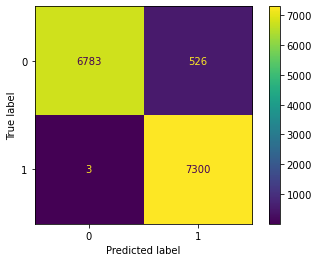

In [331]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_best_grid, X_test_final,y_test)

Perbandingan Training dan Testing pada model Random Forest Classifier

In [338]:
score_rf_train = cross_val_score(rf_best_grid, X_train_final, y_train, cv=10, scoring='f1_weighted')
score_rf_test = cross_val_score(rf_best_grid, X_test_final, y_test, cv=10, scoring='f1_weighted')
rf_f1_score_train = (score_rf_train)
rf_f1_score_test = (score_rf_test)

In [339]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rf_f1_score_train)

Scores: [0.96419955 0.96128426 0.96471551 0.96574785 0.96573793 0.9652236
 0.96075991 0.96659714 0.96711066 0.96368051]
Mean: 0.9645056927069413
Standard deviation: 0.001999097989651364


In [340]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rf_f1_score_test)

Scores: [0.90328851 0.91844344 0.9078801  0.9121665  0.90670197 0.92591038
 0.91412709 0.90662252 0.91697558 0.91220138]
Mean: 0.912431746718911
Standard deviation: 0.006421464276656408
